In [1]:
import pickle

import keras.preprocessing.sequence as k_ps
import keras.models as k_mod
import keras.layers as k_lay
import keras.optimizers as k_opt
import keras.utils as k_ut
import numpy as np
import pandas as pd
import sklearn.metrics as sk_mt
import sklearn.model_selection as sk_ms
import sklearn.preprocessing as sk_pp
import sklearn.utils as sk_ut
from utils import score, print_scores, plot_confusion_matrix

Using TensorFlow backend.


In [2]:
with open('lstm_tweets_net.pkl', 'rb') as f:
    data = pickle.load(f)
x, y = zip(*data)

In [3]:
pad_tag = '#PAD#'
max_len = max(len(xw) for xw in x)

In [4]:
flat_tmp_x = set([b for a in x for b in a])

indexed_tmp_x = {w: i + 1 for i, w in enumerate(flat_tmp_x)}
indexed_tmp_x[pad_tag] = 0
tagged_x = np.array([[indexed_tmp_x[wx] for wx in sx] for sx in x])

lb = sk_pp.LabelBinarizer()
lb.fit(y)

x_tagged_train, x_tagged_test, y_train, y_test = sk_ms.train_test_split(tagged_x, lb.transform(y), shuffle=True)

In [5]:
input_dim = len(x[0])
output_dim = len(set(y))

In [6]:
def learn_model(size, learning_rate, batch_size, epochs):
    model = k_mod.Sequential()
    model.add(k_lay.Embedding(len(flat_tmp_x) + 1, 128, input_length=max_len))
    model.add(k_lay.LSTM(size))
    model.add(k_lay.Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=k_opt.Adam(learning_rate), metrics=['accuracy'])
    model.fit(x_tagged_train, y_train, batch_size=batch_size, epochs=epochs)
    return model

In [7]:
model = learn_model(64, 0.001, 512, 5)
pred = model.predict_classes(x_tagged_test)
y_pred = lb.inverse_transform(k_ut.to_categorical(pred))
y_true = lb.inverse_transform(y_test)

Epoch 1/5
14133/14133 [==============================] - 4s 252us/step - loss: 1.3656 - acc: 0.3447
Epoch 2/5
14133/14133 [==============================] - 1s 90us/step - loss: 1.2132 - acc: 0.4576
Epoch 3/5
14133/14133 [==============================] - 1s 92us/step - loss: 1.0268 - acc: 0.5772
Epoch 4/5
14133/14133 [==============================] - 1s 89us/step - loss: 0.8637 - acc: 0.6590
Epoch 5/5
14133/14133 [==============================] - 2s 112us/step - loss: 0.7153 - acc: 0.7227


In [8]:
print_scores(*score(y_true, y_pred))

acc 0.5025466893039049
f1 0.49477621967701235
prec 0.49916204946186704
rec 0.5034572920270901


In [9]:
print(sk_mt.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      actors       0.46      0.29      0.36      1214
     athlets       0.44      0.53      0.48      1159
    musicans       0.47      0.51      0.49      1137
  politicans       0.63      0.68      0.65      1202

   micro avg       0.50      0.50      0.50      4712
   macro avg       0.50      0.50      0.49      4712
weighted avg       0.50      0.50      0.49      4712



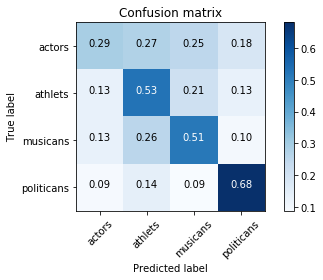

In [10]:
plot_confusion_matrix(y_true, y_pred, sorted(set(y_true)))

In [11]:
with open('../lstm.pkl', 'wb') as f:
    pickle.dump(model, f)